In [11]:
import os
import re
import requests as rq
import pandas as pd
import numpy as np
import urllib3 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  # Suppress InsecureRequestWarning

def get_marvel_character_list(character_type):
    """Returns a set of one type of Marvel Characters (either superheroes or supervillains)
    
    Using the rq.get() method, request the WikiPedia page containing the list of either character type
    defined by the user, then store the .json result into a dictionary, with the continue keyword if it 
    exists. In a loop, keys into query and categorymembers to access title, which contains the character
    name to be added into a set, requests another query with the continue key. If there is a KeyError,
    Then there is no more continue data to be keyed into.
    
    Args:
        characters: string describing the type of marvel characters ("superheroes or supervillains")
        
    Returns: 
        list: a set of the character names
    """
    
    group = set()  
    
    wpage = r"https://en.wikipedia.org/w/api.php?"
    action = r"action=query"
    format = r"format=json"
    list = r"list=categorymembers"
    title = r"cmtitle=Category:Marvel_Comics_%s" % character_type
    url = wpage + "&".join([action,format,list,title])
    
    data = rq.get(url).json()
    cont = data['continue']['cmcontinue']
    
    for entry in data['query']['categorymembers']:
        group.add(entry['title'])
    while True:
        try:
            data = rq.get(url + "&cmcontinue=%s" % cont).json()
            cont = data['continue']['cmcontinue']

            for entry in data['query']['categorymembers']:
                group.add(entry['title'])
        except KeyError:
            break
    return group

def make_groups(**offline):
    """Partitions the three main groups
    
    Defines global variables for each then makes the superheroes and supervillain
    sets. If offline, the markups are already stored on the directory, so to make
    the groups, just make a set of list of files in each directory. Else, forms the 
    superheroes and supervillains from requests (takes long) and  forms the ambiguous 
    set which is the intersection then, subtracts them from each group.
    
    Args:
        offline: a keyword argument specifying if the groups should be made from 
        the existing directory or from requesting. The former is much faster as it
        just accesses the already-stored markups on each of the character folders,
        instead of requesting all over again.
    Returns:
        a tuple of superheroes, supervillains, ambiguous in that order.
    """
    
    def clean_data(data):
        """Cleans the set by removing entries with 'Category' or 'List of'."""
        for item in data.copy():
            if item.find("Category") != -1 or item.find("List of") != -1:
                data.remove(item)
        return data
    
    global superheroes, supervillains, ambiguous
    
    if offline:  # Must have the the stored directory hierarchy already.
        for group, faction in enumerate(['superheroes', 'supervillains', 'ambiguous']):  # Each file has a .txt extension
            faction_chars = [c[:-4] for c in os.listdir('characters/%s' % faction)]      # So splice each until [:-4]
            
            if group == 0:
                superheroes = clean_data(faction_chars)
                
            elif group == 1:
                supervillains = clean_data(faction_chars)
            
            elif group == 2:
                ambiguous = clean_data(faction_chars)
        
    else:          
        superheroes = get_marvel_character_list("superheroes")
        supervillains = get_marvel_character_list("supervillains")
        ambiguous = superheroes.intersection(supervillains)
        superheroes -= ambiguous
        supervillains -= ambiguous
        
    return superheroes, supervillains, ambiguous

superheroes, supervillains, ambiguous = make_groups(offline=True)

In [11]:
def verify_fname(string):
    """Replaces illegal file name characters in the string to legal ones"""

    if string.find(r'"') != -1:
        string = string.replace(r'"', "",2)
    if string.find(r'/') != -1:
        string = string.replace(r'/','or')
    if string.find(r':') != -1:
        string = string.replace(r':', '')
    return string

In [4]:
def get_alliances(char):
    """Returns a list of alliances of char from markup
    
    Changes char to a valid file name to access its .txt file. Store markup into 
    a variable to be searched by two RegEx's, one that extracts the 'alliances' field
    of the markup, and one that extracts a four-digit number from it.. If there is
    an IndexError, then char has no alliances (the list is empty). 
    
    Args:
        char: the character whose alliances is to be returned
    
    Returns:
        
    """
    char = verify_fname(char)
    for faction in ['superheroes', 'supervillains', 'ambiguous']:
        faction_chars = [c[:-4] for c in os.listdir("characters/%s" % faction)]
        if char in faction_chars:
            break

    with open("characters/%s/%s.txt" % (faction,char)) as f:
        line = f.read()
        
    try:
        text = re.findall(r"\| *alliances[\w\W]+?\\n\|", line)[0]
    except IndexError:
        return
    
    raw_alliances = re.findall(r"\[\[(.*?)\]\]", text)
    
    alliance_list = []
    
    """In a case that an alliance is split into two parts by '|', take the second one (cleaner)"""
    for text in raw_alliances:
        if text.find("|") != -1:
            alliance_list.append(text.split('|')[1])
        else:
            alliance_list.append(text)
            
    return alliance_list

In [5]:
all_heroes = sorted(superheroes + supervillains + ambiguous)

In [6]:
print(get_alliances("Captain America"))

['All-Winners Squad', 'Avengers', 'Avengers Unity Division', 'Illuminati', 'Invaders', 'Landau, Luckman, and Lake', 'New Avengers', 'Project: Rebirth', 'Redeemers', 'S.H.I.E.L.D.', 'Secret Avengers', 'Secret Avengers', 'Secret Defenders', 'U.S. Army', 'New York City Police Department']


In [7]:
def all_teams(**progress):
    
    global all_heroes
    conflicts = set()
    alliances = set()

    for name in all_heroes:
        
        if progress:
            print ("Getting alliance for %s" % name)
            print ("================================================")
            
        try:
            teams = get_alliances(name)
            for team in teams:
                alliances.add(team)
        except (TypeError,IOError):  # If error, the 'alliances' field was not found in the markup.             
            conflicts.add(name)      # Delete later from alliances
            continue
            
    all_heroes = set(all_heroes) - conflicts
    all_heroes = sorted(all_heroes)
    
    return alliances

all_alliances = all_teams()

> **Ex.4.1.3**: Write a function that takes the name of a character and returns a vector representation of the team alliances for that character. The length of the returned list will be `len(all_teams)` and have 0s in the places corresponding to teams that the character is not on, and 1s in the places corresponding to teams the character is on. Print the sum of the list returned when the input to the function is Iron man.

In [8]:
def alliance_vector(character):
    alliances = get_alliances(character)
    
    global all_alliances
    
    team_vector = []
    for team in all_alliances:
        if team in alliances:
            team_vector.append(1)
        else:
            team_vector.append(0)
    return team_vector


> **Ex. 4.1.4**: Create the team alliance matrix for the data. This is your feature matrix for the classification problem you will solve later in this exercise set. Therefore, you should also—in a seperate *target* array—store whether characters are heros (denote by 1) or villains (denote by 0). For now, skip ambiguous characters, but write your code in such a way that it won't be too hard to redo this for ambiguous characters. Skip characters that have no team alliances. Print the shapes of your matrix and target array.

In [9]:
def alliance_matrix(**write):
    """DOCSTRING"""
    
    global all_heroes  # grab this global variable defined earlier
    
    def get_targets():
        """"""
        targets = []

        for character in all_heroes:
            if character in superheroes:
                targets.append(1)
            elif character in supervillains:
                targets.append(0)
            elif character in ambiguous:
                targets.append(2)
        return np.array(targets)
    
    def get_features(**progress):
        """Gets the feature matrix of all the heroes"""
        features = []

        for hero in all_heroes:
            if progress:
                print ("Getting alliance vector for %s" % hero)
            features.append(alliance_vector(hero))

        return np.array(features)
    
    def clean_data(df):
        """Gets the indices (names) which have no alliances and drop them from the DataFrame"""
        to_clean = df.iloc[:,:-1]  # Take df without the target array
        df = df.drop(to_clean[to_clean.sum(1) == 0].index,axis=0)            
        
        return df
    
    targets = get_targets()
    features = get_features()
    
    data = pd.DataFrame(data=features, index=all_heroes, columns=all_alliances) 
    data['faction'] = pd.Series(data=targets,index=all_heroes)               # Appends the target array to the end of df
    
    data = clean_data(data)
    
    if write:
        data.to_csv("marvel.csv",sep=',',encoding='utf-8')
        
    return data

marvel = alliance_matrix(write=True)

In [10]:
marvel

,Fear Lords,Project: Rebirth,Dream Team,Alchemax,Indian Police Force,The Redeemers,The Hellfire Club,New Ultimates,Uncanny Avengers,Phalanx,...,U-Men,Folding Circle,U.S. military,New X-Men,Amazons,Beyonders,Point Men,Brotherhood of Evil Mutants,Galactic Council,faction
Abigail Brand,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Abner Jenkins,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Abomination (comics),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abraham Cornelius,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Absorbing Man,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adam Warlock,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Adept (comics),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Adrienne Frost,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ahab (comics),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aikku Jokinen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Part 2: Model fitting

> **Ex. 4.2.1**: Train a classifier on all of your data and test its accuracy.

>* If your team alliance matrix is `X_ta` and your target array is `y_ta` you can do this by instantiating a model like:
>
        from sklearn.naive_bayes import BernoulliNB
        model = BernoulliNB()
        model.fit(X_ta, y_ta)  # <--- This is the training/fitting/learning step
        
> The `BernoulliNB` is a version of the Naive Bayes classifier which associates certain features with labels and asks what the probability of a label for a data point is given its features. You are free to use any other classifier if you want. Popular ones are trees, random forests, support vector machines, feed forward neural networks, logistic regression, and the list goes on. With `sklearn`, they are just as easy to employ as the `BernoulliNB` classifier.


>1. Test the accuracy of your model. You can use the `.predict` method on the `model` object to get predictions for a matrix of data points. Report the accuracy of your model on the same data that you trained the model on, alongside the baseline accuracy of a "dumb" model that only guesses for the majority class.

>2. Report the precision, recall and F1 scores, with respect to the minority class (heroes). `sklearn` has implementations that you can use if you are short for time. Extra credit for doing it using only basic linear algebra operations with `numpy`, though.

In [17]:


model = BernoulliNB()

# feature array
marvel_feature = marvel.iloc[:,:-1]

# target array
marvel_target = marvel['faction']

# train, fit, and learn 
model.fit(marvel_feature, marvel_target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [28]:
b = model.predict(marvel_feature)
_score(marvel_target, b, average='macro')

0.6649401230229944

In [35]:
def predict_on_model(model, features, targets):
    """DOCSTRING"""
    y_pred = model.predict(features)
    
    print("Reporting metrics:")
    
    metrics = [accuracy_score(targets, y_pred), 
               precision_score(targets, y_pred, average='weighted'),
               f1_score(targets, y_pred, average='weighted'),
               recall_score(targets, y_pred, average='weighted')]
    
    # Quick little intro to myself about f-string formatting. Will try to use this from now on. Read more about f-strings (PEP 498)
    print(f"Accuracy: {metrics[0]:.4} \nPrecision: {metrics[1]:.4} \nF1 score: {metrics[2]:.4} \nRecall: {metrics[3]:.4}")
    

    
predict_on_model(model,marvel_feature, marvel_target)

Reporting metrics:
Accuracy: 0.8397 
Precision: 0.8367 
F1 score: 0.8141 
Recall: 0.8397


### Part 3: Model evaluation

> **Ex. 4.3.1**: Investigate how well your model generalizes. You may have noticed that the performance seemed a little too good to be true in Ex 4.2.1.
1. Why did you get such a high accuracy in the previous exercise?
2. Split your data into a test and training set of equal size. Train the model only on the training set and report its accuracy and F1 scores (for both classes) on both the training and test sets.
3. Comment on the difference you observe.

> *Hint: Watch out for unbalanced class proportions! You may want to randomly reorder the rows of your datapoints and target labels so your training and test sets have the same amount of heroes and villains.*

In [46]:
from sklearn.utils import shuffle
def evaluate_model(model):
    
    # Shuffle to fix unbalanced class proportion. 
    alliance_matrix = shuffle(marvel)
    
    # Splice row-wise first half for training set, and the rest for test set
    training_set = alliance_matrix.iloc[:len(alliance_matrix)//2,:]
    test_set = alliance_matrix.iloc[(len(alliance_matrix)//2):,:]

    # Train only on the training set
    model2.fit(training_set,training_set.faction)

    training_pred = model2.predict(training_set)
    test_pred = model2.predict(test_set)

    print(f"Training accuracy is: {accuracy_score(training_set.faction, training_pred):.4}\nTraining F1 score is: {f1_score(training_set.faction, training_pred,average='weighted'):.4} ")
    print(f"Testing accuracy is: {accuracy_score(test_set.faction, test_pred):.4}\nTesting F1 score is: {f1_score(test_set.faction, test_pred,average='weighted'):.4} ")
evaluate_model(model)

Training accuracy is: 0.9034
Training F1 score is: 0.8677 
Testing accuracy is: 0.8958
Testing F1 score is: 0.8504 


> **Ex. 4.3.2**: Implement cross validation. The performance of a classifier is strongly dependent on the amount of data it is trained on. In Ex. 4.3.1 you train it on only half of the data and test it on the other half. If you rerun that code multiple times, with random 50/50 partitions, you are gonna see a lot of uncertainty in performance. Cross validation solves this problem by training on a larger subset of the data and testing on a smaller one, and taking the average performance over K-folds of this process.
1. Implement cross validation over $K=10$ folds. For each fold you must record the training and test accuracies. In the end, visualize the distributions of test- and training accuracy as histograms in the same plot. It's important that you comment on the result.

In [58]:
def cross_validation(ml_data, k=10 , shuffle=False):
    """Cross validates the model to evaluate its accuracy with k number of folds
    
    First, partitions the data into an array that contains k number of (test, training) tuples 
    Then define a model. In this case, we are using BernoulliNB(). For each fold of the partitioned
    array, perform the following: 1) Split each data set into their features and target arrays.
    2) Train only on the current training data set. 3) Report accuracy on both data sets 4) Append the 
    accuracy on a list to be plotted.
    
    Args:
        ml_data: pandas DataFrame containing the feature matrix and the target array appended 
            at the end.
        k: number of folds. Use k=10 by default
    """
    def partition(data,k, shuffle=False):
        
        # Shuffle data
        if shuffle: 
            data = shuffle(data)
        
        parted = []

        # Number of elements in each k partitions
        num = len(data)//k 

        for i in range(k):

            # Partition by the row. middle is test data and start+end is training data
            # .iloc[row_start:row_end, column_start:column_end]
            start = data.iloc[:(i*num),:]
            middle = data.iloc[i*num:(i+1)*num,:]
            end = data.iloc[(i+1)*num:,:]

            parted.append((middle,pd.concat([start,end])))

        #list of tuples of (test_data, training data)
        return parted 
    
    
    #define a new BernoulliNB model
    model = BernoulliNB()
    
    #parititon DataFrame into k folds 
    folds = partition(ml_data,k)
    
    #stores the accs to plot later
    train_accs = []
    test_accs = []
    
    index = 1
    for test_data, train_data in folds:
        
        headline = "Fold %d" % index
        print (headline + "\n" + "-"*len(headline))
        
        # Define the target arrays of the current train and test data
        train_target = train_data.faction
        test_target = test_data.faction
        
        # Set train data and test data to not include the target array
        train_data = train_data.iloc[:,:-1]
        test_data = test_data.iloc[:,:-1]
        
        # Train only on current training data
        model.fit(train_data,train_target)
        
        # Predict on the train data and test data
        train_pred = model.predict(train_data)
        test_pred = model.predict(test_data)
        
        # Make the train_data and train_pred to be both numpy.arrays for comparison.
        # Maybe this is not really needed.
        train_data = np.array(train_target)
        test_data = np.array(test_target)
        
        train_acc = accuracy_score(train_data,train_pred)
        test_acc = accuracy_score(test_data,test_pred)
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print (f"    train acc: {train_acc:.4}")
        print (f"    test acc: {test_acc:.4}")
        
        index += 1
        
    print (f"average train accuracy: {np.mean(train_accs):.4}\naverage test accuracy: {np.mean(test_accs):.4}")
    
    return train_accs, test_accs


Fold 1
------
    train acc: 0.8366
    test acc: 0.8047
Fold 2
------
    train acc: 0.8323
    test acc: 0.7656
Fold 3
------
    train acc: 0.8358
    test acc: 0.7656
Fold 4
------
    train acc: 0.8358
    test acc: 0.7422
Fold 5
------
    train acc: 0.8375
    test acc: 0.7578
Fold 6
------
    train acc: 0.8358
    test acc: 0.8281
Fold 7
------
    train acc: 0.8392
    test acc: 0.7422
Fold 8
------
    train acc: 0.8366
    test acc: 0.75
Fold 9
------
    train acc: 0.8358
    test acc: 0.7969
Fold 10
-------
    train acc: 0.8332
    test acc: 0.7734
average train accuracy: 0.8359
average test accuracy: 0.7727


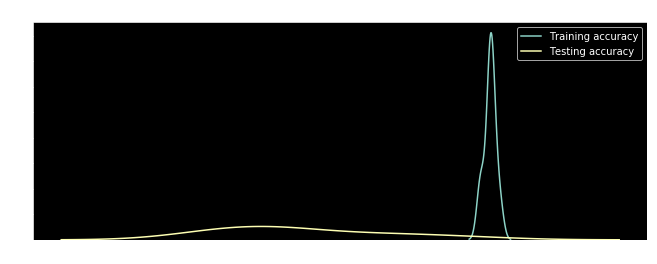

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

train_accs, test_accs = cross_validation(marvel)

plt.figure(figsize=(11,4))
plt.style.use('dark_background')

sns.kdeplot(train_accs, label='Training accuracy')
sns.kdeplot(test_accs, label='Testing accuracy')
plt.title("Distribution of Training and Testing accuracy")
plt.legend(loc=0)

plt.show()

### Part 4: Predicting good vs. evil

>**Ex. 4.4.1**: Let's put our classifier to use!
* Retrain your model on all of your data.
* Create a team alliance representation of the ambiguous characters
* Use the model the estimate the probability that each character is a villain (let's call this *villainness*). You can use the `.predict_proba` method on the model to get probability estimates rather than class assignments.
* **Visualize the "heroness" distribution for all ambiguous characters**. Comment on the result.